In [308]:
# Author: Lucas Glasner
# Date: 2024-06-09
# Contact: lgvivanco96@gmail.com
library("openxlsx")
library("tibble")
source("fit_utils.R")
source("test_utils.R")


# Extract non-NA values and their corresponding IDs from a vector or data frame
# column.
# Args: data: A numeric vector or data frame containing sample data.
#       col: (Optional) The column name to extract from if data is a data frame.
# Returns: A list with two elements:
#          - ndata: The non-NA values.
#          - ids: The corresponding row names or indices of the non-NA values.
extract_non_na <- function(data, col = NULL) {
  if (is.data.frame(data)) {
    # If col is not provided and data has only one column, use that column
    if (is.null(col)) {
      if (ncol(data) != 1) {
        stop("Column name must be provided for data with multiple columns.")
      }
      col <- colnames(data)[1]
    }
    ndata <- data[[col]]
    ndata <- ndata[!is.na(ndata)]
    ids <- rownames(data)[!is.na(data)]
  } else {
    # If data is a vector
    ndata <- data[!is.na(data)]
    ids <- seq_along(data)[!is.na(data)]
  }
  list(ndata = ndata, ids = ids)
}

# Compute sample statistics (mean, sd, skewness, kurtosis, min, max,
# zero probability) for a vector or data frame column.
# Args: data: A numeric vector or data frame containing sample data.
#       col: (Optional) The column name to extract from if data is a data frame.
#       remove_zeros: Logical; if TRUE, zero values are removed before
#                     computing statistics.
# Returns: A matrix with named statistics as columns.
get_sample_statistics <- function(data, col = NULL, remove_zeros = FALSE) {
  extracted <- extract_non_na(data, col)
  ndata <- extracted$ndata
  # Calculate statistics
  pnonzero <- 1 - sum(ndata == 0) / length(ndata)
  if (remove_zeros) {
    ndata <- ndata[ndata > 0]
  }
  sample_moms <- as.list(moms(ndata))
  ndata_mean <- sample_moms$mean
  ndata_sd <- sqrt(sample_moms$variance)
  ndata_skw <- sample_moms$skewness
  ndata_kur <- sample_moms$kurtosis
  ndata_min <- min(ndata)
  ndata_max <- max(ndata)
  stats <- list(mean = ndata_mean, sd = ndata_sd,
                skew = ndata_skw, kurt = ndata_kur,
                min = ndata_min, max = ndata_max,
                pnonzero = pnonzero)
  return(as.data.frame(stats))
}

# Build an exceedance probability table for a vector or data frame column.
# Args: data: A numeric vector or data frame containing sample data.
#       col: (Optional) The column name to extract from if data is a data frame.
#       remove_zeros: Logical; if TRUE, zero values are removed before building
#                     the table.
# Returns: A data frame with columns: rank, data, id, pexc (empirical
#          probability), rperiod (recurrence period).
build_eva_table <- function(data, col = NULL, remove_zeros = FALSE) {
  extracted <- extract_non_na(data, col)
  ndata <- extracted$ndata
  ids <- extracted$ids
  # Remove zero values
  pnonzero <- 1 - sum(ndata == 0) / length(ndata)
  if (remove_zeros) {
    ndata <- ndata[ndata > 0]
    ids <- ids[ndata > 0]
  }
  norder <- order(ndata, decreasing = TRUE) # Order the data
  ids  <- ids[norder]
  ndata  <- ndata[norder]
  # Calculate ranks and exceedance probabilities
  ndata_rank <- rank(-ndata, ties.method = "max")
  ndata_pexc <- ndata_rank / (length(ndata) + 1) # Empirical probability
  if (pnonzero < 1) {
    ndata_pexc <- ndata_pexc * pnonzero # Adjust for zero values
  }

  eva_table <- list(rank = ndata_rank, data = ndata,
                    id = ids, pexc = ndata_pexc, rperiod = 1 / ndata_pexc)
  eva_table <- as.data.frame(eva_table)
  return(eva_table)
}

# Compute model quantiles for given exceedance probabilities.
# Args:
#   model_pexc: Numeric vector of exceedance probabilities for the model.
#   model_rperiods: Numeric vector of recurrence periods for the model.
#   statistics: Data frame or list of sample statistics (must include pnonzero).
#   distr: Character string specifying the distribution name.
#   params: List or vector of fitted distribution parameters.
#   fix_zeros: Logical; if TRUE, adjusts quantiles for zero-inflated data.
# Returns:
#   Numeric vector of model quantiles corresponding to model_rperiods.
get_model_quant <- function(model_pexc, statistics, distr, params,
                            fix_zeros) {
  model_rperiods <- 1 / model_pexc
  model_quant <- qprobmodel((1 - model_pexc), distr = distr, params = params)
  if (fix_zeros) {
    model_quant <- approx(x = model_rperiods / statistics$pnonzero,
                          y = model_quant,
                          xout = model_rperiods)$y
  }
  model_quant[model_quant <= 0]   <- 0 # Ensure no negative quantiles
  model_quant[is.na(model_quant)] <- 0 # Handle NA values
  return(model_quant)
}

# Fit a probability model to exceedance data and compute quantiles and metrics.
# Args:
#   data: Numeric vector or data frame containing sample data.
#   method: Character string specifying the fitting method.
#   distr: Character string specifying the distribution name.
#   model_rperiods: Numeric vector of recurrence periods for the model.
#   target_rperiods: Numeric vector of target recurrence periods for
#   quantile estimation.
#   fix_zeros: Logical; if TRUE, zero values are handled specially.
# Returns:
#   A list containing:
#     - eva_table: Data frame of exceedance data.
#     - statistics: Data frame of sample statistics.
#     - distr: Distribution name.
#     - method: Fitting method.
#     - params: Fitted distribution parameters.
#     - model_pred: Model predictions at observed recurrence periods.
#     - model_quant: Data frame of model quantiles at model_rperiods.
#     - target_quant: Data frame of model quantiles at target_rperiods.
#     - metrics: Data frame of goodness-of-fit metrics.
run_probmodel <- function(data, method, distr,
                          model_rperiods, target_rperiods,
                          fix_zeros) {
  name <- paste(distr, method, sep = "_")
  model_pexc <- 1 / model_rperiods
  eva_table <- build_eva_table(data, remove_zeros = fix_zeros)
  statistics <- get_sample_statistics(data, remove_zeros = fix_zeros)
  params <- fit_probmodel(eva_table$data, distr = distr, method = method)
  model_quant <- get_model_quant(model_pexc, statistics,
                                 distr, params, fix_zeros)
  model_pred <- approx(x = model_rperiods,
                       y = model_quant,
                       xout = eva_table$rperiod)$y
  target_quant <- approx(x = model_rperiods,
                         y = model_quant,
                         xout = target_rperiods)$y
  metrics <- gofmetrics(eva_table$data, model_pred,
                        distr = distr, params = params)

  model_quant <- data.frame(model_quant, row.names = model_rperiods)
  target_quant <- data.frame(target_quant, row.names = target_rperiods)
  colnames(model_quant) <- name
  colnames(target_quant) <- name
  colnames(metrics) <- name
  list(
    eva_table = eva_table,
    statistics = statistics,
    distr = distr,
    method = method,
    params = params,
    model_pred = model_pred,
    model_quant = model_quant,
    target_quant = target_quant,
    metrics = metrics
  )
}

pad_and_bind <- function(...) {
  lst       <- list(...)             # all vectors
  max_len   <- max(lengths(lst))     # longest length
  padded    <- lapply(lst, function(x) c(x, rep(NA, max_len - length(x))))
  do.call(rbind, padded)             # or change to rbind() for top‑to‑bottom
}

In [309]:
path <- "data/Analisis_de_Frecuencia/v3/prmax_mm24h_ConRelleno.xlsx"
outdir <- "data/Analisis_de_Frecuencia/v3/"
sheet <- "prmax_mm24h_filled"
df <- read.xlsx(path, sheet = sheet, colNames = TRUE, rowNames = TRUE)
colnames(df) <- gsub("\\.", " ", colnames(df))
colnames(df) <- gsub("AD ", "AD.", colnames(df))
colnames(df) <- gsub("AP ", "AP.", colnames(df))
print(colnames(df))
col             <- "AGUAS VERDES"
dir.create(paste(outdir, col, sep = "/"), showWarnings = FALSE)


fix_zeros       <- TRUE
target_rperiods <- c(2, 5, 10, 20, 25, 50, 75, 100, 150, 200)
model_rperiods  <- c(seq(1.001, 1.009, 0.001), seq(1.01, 1.09, 0.01),
                     seq(1.1, 5, 0.1), seq(10, 1000, 5))
methods <- c("mle", "mme", "lmme")
distrs  <- c("norm", "lognorm", "gamma", "pearson3",
             "logpearson3", "gumbel", "gev")

 [1] "CALAMA"                 "AD. CALAMA DMC"         "SIERRA GORDA"          
 [4] "BAQUEDANO"              "CERRO MORENO DMC"       "PEINE"                 
 [7] "AGUAS VERDES"           "TAL-TAL"                "LAS VEGAS"             
[10] "PASTOS GRANDES"         "CALDERA AP. DMC"        "COPIAPO"               
[13] "JORQUERA EN LA GUARDIA" "LOS LOROS"             


In [310]:
results <- list()
for (method in methods) {
  for (distr in distrs) {
    tryCatch({
      result <- run_probmodel(df[col], method, distr,
                              model_rperiods, target_rperiods,
                              fix_zeros)
      results[[paste(distr, method, sep = "_")]] <- result
    }, error = function(e) {
      message(sprintf("Error in run_probmodel with method = %s, distr = %s: %s",
                      method, distr, e$message))
    })
  }
}

eva_table <- results[[1]]$eva_table
statistics <- results[[1]]$statistics
metrics <- do.call(cbind, lapply(results, function(res) res$metrics))
models  <- do.call(cbind, lapply(results, function(res) res$model_quant))
targets <- do.call(cbind, lapply(results, function(res) res$target_quant))
params <- do.call(pad_and_bind, lapply(results, function(res) res$params))
params <- as.data.frame(params)
colnames(params) <- c("loc", "scale", "shape")

metrics <- metrics[, order(t(-metrics["adpvalue", ]))]
models  <- models[, colnames(metrics)]
targets <- targets[, colnames(metrics)]
params  <- params[colnames(metrics), ]

Warning message in ks.test.default(x, pprobmodel, distr, params):
"ties should not be present for the one-sample Kolmogorov-Smirnov test"
Warning message in ks.test.default(x, pprobmodel, distr, params):
"ties should not be present for the one-sample Kolmogorov-Smirnov test"
Warning message in ks.test.default(x, pprobmodel, distr, params):
"ties should not be present for the one-sample Kolmogorov-Smirnov test"
Warning message in ks.test.default(x, pprobmodel, distr, params):
"ties should not be present for the one-sample Kolmogorov-Smirnov test"
Warning message in ks.test.default(x, pprobmodel, distr, params):
"ties should not be present for the one-sample Kolmogorov-Smirnov test"
Warning message in fitdist(x, dist = "gumbel", method = method, start = fgumbel(x), :
"The dgumbel function should return a vector of with NaN values when input has inconsistent parameters and not raise an error"
Warning message in fitdist(x, dist = "gumbel", method = method, start = fgumbel(x), :
"The pgumbe

png 
  3

png 
  2

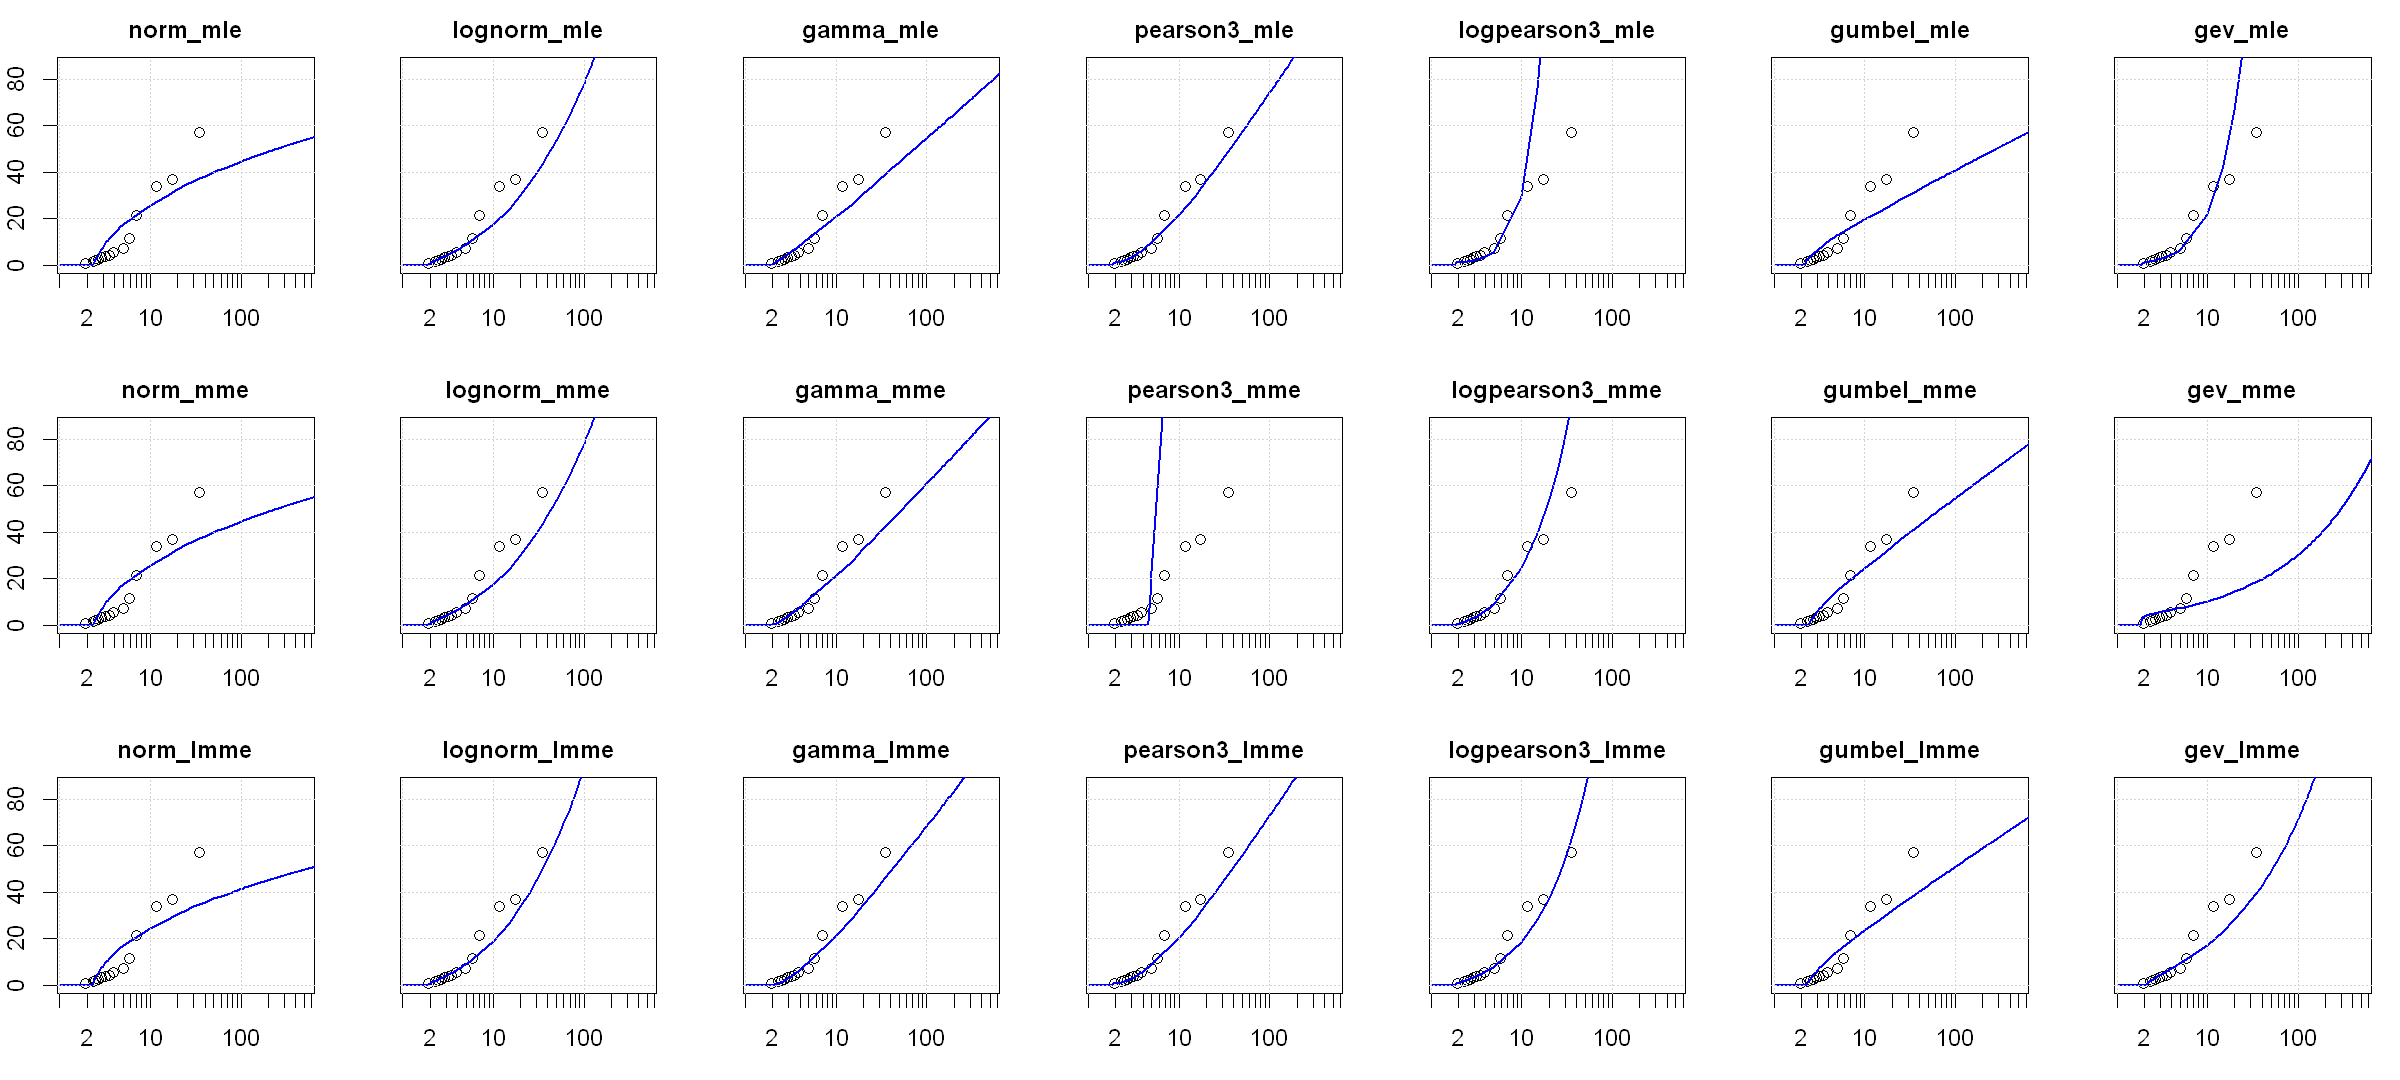

In [311]:

options(repr.plot.width = 20, repr.plot.height = 9)
par(mfrow = c(3, 7), mar = c(3, 2, 2, 1), cex = 1.2)

axis_ticks <- c(1, 2, 3, 4, 5, 6, 7, 8, 9,
                10, 20, 30, 40, 50, 60, 70, 80, 90,
                100, 200, 300, 400, 500, 600, 700, 800, 900,
                1000)
axis_labels <- rep(NA, length(axis_ticks))
mask <- axis_ticks %in% c(2, 10, 100, 1000)
axis_labels[mask] <- axis_ticks[mask]

for (i in seq_along(results)) {
  res <- results[[i]]
  y_axis <- ((i - 1) %% 7) == 0
  plot(res$eva_table$rperiod, res$eva_table$data, log = "x",
     xlab = "T",
     xlim = c(1.2, 500),
     ylim = c(0, eva_table[1, 2] * 1.5),
     yaxt = if (y_axis) "s" else "n",
     xaxt = "n",
     main = names(results)[i], cex.main = 1)
  axis(1, at = axis_ticks, labels = axis_labels)
  lines(model_rperiods, res$model_quant[, 1],
    col = "blue", lwd = 2)
  grid()
}

par(mfrow = c(1, 1))

dev.copy(png,
         filename = file.path(outdir, paste0(col, "/ModelsPerformance.png")),
         width = 1500, height = 900, res = 100)
dev.off()

In [312]:
targets

,logpearson3_lmme,lognorm_lmme,lognorm_mle,lognorm_mme,logpearson3_mme,pearson3_lmme,gev_mle,gamma_mme,gev_lmme,gamma_mle,⋯,gumbel_mme,gumbel_lmme,gumbel_mle,norm_mle,norm_mme,norm_lmme,pearson3_mle,pearson3_mme,logpearson3_mle,gev_mme
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,1.064948,0.9359898,1.050012,1.050012,0.6749326,0.915944,1.238333,0.3415899,0.000000,0.6262293,⋯,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.158297,0.00000,1.175713,3.943398
5,8.084919,9.1585376,8.902726,8.902726,9.3271961,9.043454,6.698314,11.1101227,9.485231,11.7173681,⋯,14.91002,14.68197,12.97044,17.60331,17.60331,17.08094,10.047323,23.31748,5.946737,7.529773
10,18.584754,19.0475138,17.663682,17.663682,24.6782886,20.627368,22.022756,21.3725947,17.411948,20.9346672,⋯,24.62338,23.55658,19.80209,25.95160,25.95160,24.59901,21.926193,191.10033,29.731991,10.489421
20,37.507581,33.7576534,30.220711,30.220711,54.0972279,35.017464,66.329885,32.8866286,28.252552,30.9378215,⋯,34.01996,32.14177,26.41095,32.73739,32.73739,30.70996,36.434257,362.60756,137.412694,14.510828
25,46.162353,39.6061176,35.101072,35.101072,67.9478778,39.882235,94.416680,36.6137586,32.463282,34.1275498,⋯,36.87831,34.75330,28.42130,34.58476,34.58476,32.37362,41.304674,415.76258,229.366963,16.065848
50,84.876221,62.3063930,53.689106,53.689106,131.1195911,56.020244,278.173875,48.6875390,48.857730,44.3723796,⋯,45.84791,42.94837,34.72984,39.94277,39.94277,37.19878,57.400963,583.65422,1154.209545,22.095059
75,118.635059,79.0244197,67.090374,67.090374,187.0855081,65.778993,521.664947,55.8176553,61.172072,50.3691349,⋯,50.98381,47.64079,38.34206,42.72775,42.72775,39.70680,67.098932,680.19540,3026.022234,26.601079
100,149.291236,92.6333974,77.864108,77.864108,238.2339038,72.802033,814.624733,60.8935348,71.423116,54.6203717,⋯,54.59181,50.93724,40.87966,44.58283,44.58283,41.37740,74.066753,748.04791,6050.654273,30.340197
150,204.520671,114.5673127,95.023834,95.023834,330.7452332,82.831848,1525.693798,68.0796018,88.429413,60.6183807,⋯,59.64790,55.55673,44.43573,47.06048,47.06048,43.60865,84.004725,843.09441,16220.661797,36.523514


In [313]:
colnames(df)

[1] "CALAMA"                 "AD. CALAMA DMC"         "SIERRA GORDA"          
 [4] "BAQUEDANO"              "CERRO MORENO DMC"       "PEINE"                 
 [7] "AGUAS VERDES"           "TAL-TAL"                "LAS VEGAS"             
[10] "PASTOS GRANDES"         "CALDERA AP. DMC"        "COPIAPO"               
[13] "JORQUERA EN LA GUARDIA" "LOS LOROS"

In [314]:
selected_models <- list()
selected_models["CALAMA"] <- "logpearson3_lmme"
selected_models["AD. CALAMA DMC"] <- "pearson3_lmme"
selected_models["SIERRA GORDA"] <- "lognorm_lmme"
selected_models["BAQUEDANO"] <- "lognorm_lmme"
selected_models["CERRO MORENO DMC"] <- "logpearson3_lmme"
selected_models["PEINE"] <- "logpearson3_lmme"
selected_models["AGUAS VERDES"] <- "pearson3_lmme"
selected_models["TAL-TAL"] <- "pearson3_lmme"
selected_models["LAS VEGAS"] <- "pearson3_lmme"
selected_models["PASTOS GRANDES"] <- "gev_lmme"
selected_models["CALDERA AP. DMC"] <- "pearson3_mle"
selected_models["COPIAPO"] <- "pearson3_mle"
selected_models["JORQUERA EN LA GUARDIA"] <- "pearson3_mle"
selected_models["LOS LOROS"] <- "pearson3_mle"

png 
  3

png 
  2

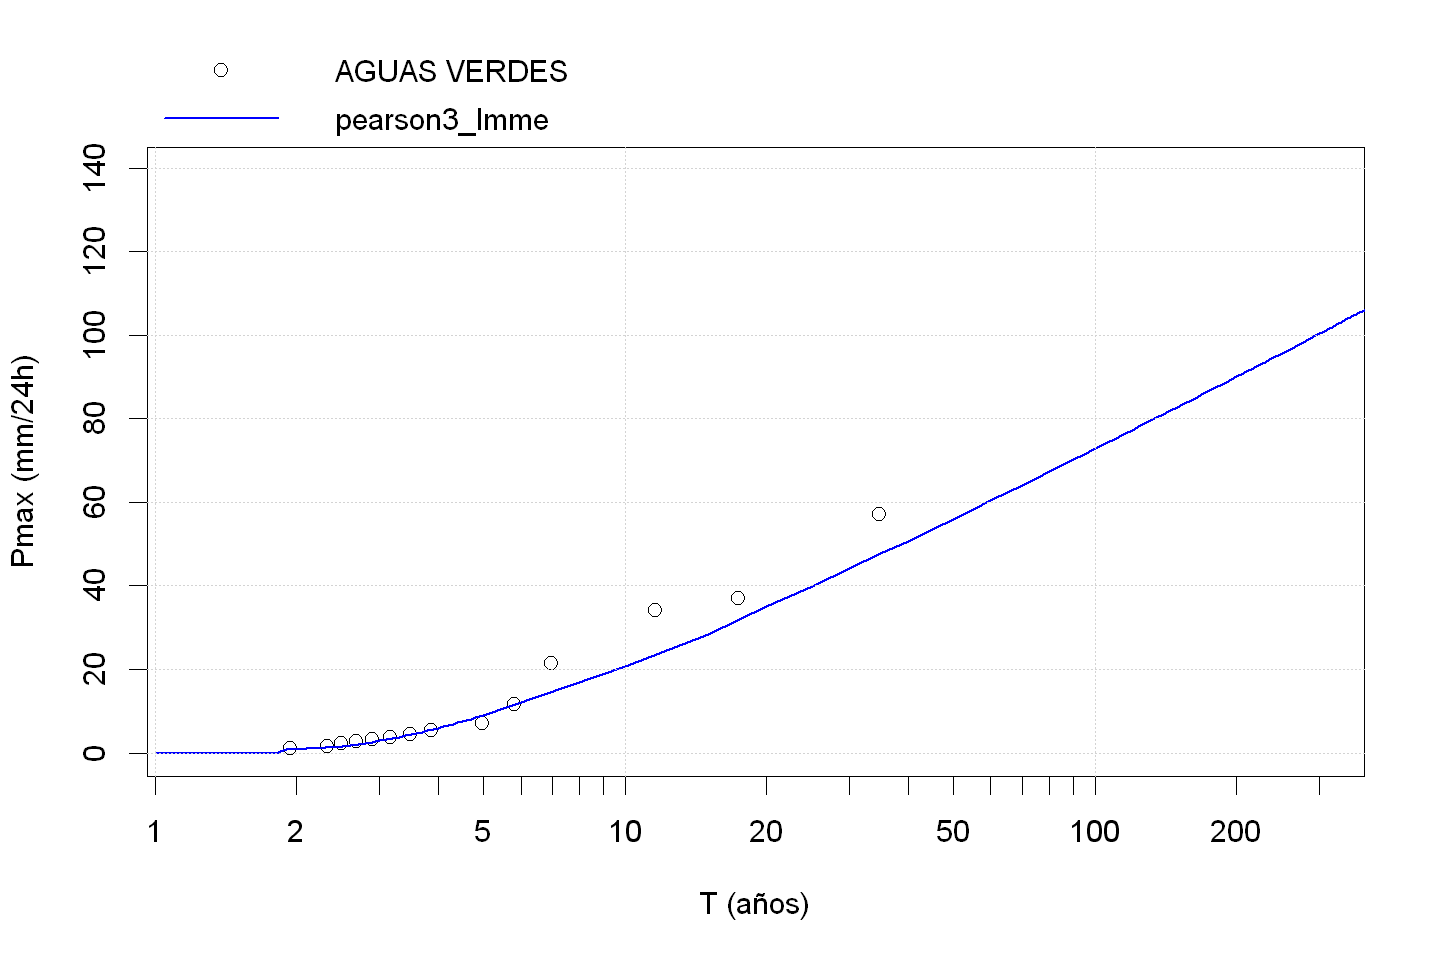

In [315]:
selected_model <- selected_models[[col]]

options(repr.plot.width = 12, repr.plot.height = 8)
par(cex = 1.5)
res <- results[[selected_model]]
plot(res$eva_table$rperiod, res$eva_table$data, log = "x",
  xlim = c(1.2, 300), ylim = c(0, statistics$mean+8*statistics$sd),
  xlab = "T (años)", ylab = "Pmax (mm/24h)")
lines(model_rperiods, res$model_quant[, 1],
   col = "blue", lwd = 2)
axis(1, at = axis_ticks, labels = axis_labels)
grid()
legend("topleft",
       inset = c(0, -0.2), xpd = TRUE,
       legend = c(col, selected_model),
       col = c("black", "blue"),
       lty = c(NA, 1), pch = c(1, NA), lwd = c(NA, 2), bty = "n") # bty="n" for no box
dev.copy(png,
  filename = file.path(outdir, paste0(col, "/FinalModel.png")),
  width = 1400, height = 900, res = 100)
dev.off()


In [316]:
# Write results into disk as an excel spreadsheet
wb <- createWorkbook()

addWorksheet(wb, sheetName = "EVA_Table")
addWorksheet(wb, sheetName = "Statistics")
addWorksheet(wb, sheetName = "CalibrationParams")
addWorksheet(wb, sheetName = "FitModels")
addWorksheet(wb, sheetName = "FitResults")
addWorksheet(wb, sheetName = "PerformanceMetrics")
addWorksheet(wb, sheetName = "FinalModel")
addWorksheet(wb, sheetName = "FinalResults")
addWorksheet(wb, sheetName = "FinalMetrics")

writeData(wb, sheet = "EVA_Table", x = eva_table)
writeData(wb, sheet = "Statistics", x = statistics)
writeData(wb, sheet = "CalibrationParams",
          x = tibble::rownames_to_column(params, "distr"))
writeData(wb, sheet = "FitModels",
          x = tibble::rownames_to_column(models, "T"))
writeData(wb, sheet = "FitResults",
          x = tibble::rownames_to_column(targets, "T"))
writeData(wb, sheet = "PerformanceMetrics",
          x = tibble::rownames_to_column(metrics, "metric"))
writeData(wb, sheet = "FinalModel",
          x = tibble::rownames_to_column(models[selected_model], "T"))
writeData(wb, sheet = "FinalResults",
          x = tibble::rownames_to_column(targets[selected_model], "T"))
writeData(wb, sheet = "FinalMetrics",
          x = tibble::rownames_to_column(metrics[selected_model], "metric"))

saveWorkbook(wb, file = file.path(outdir, paste0(col, '/', col, ".xlsx")),
             overwrite = TRUE)